In [ ]:
#default_exp vision.moco

# MoCo

> **MoCo**: [Momentum Contrast for Unsupervised Visual Representation Learning](https://arxiv.org/pdf/1911.05722.pdf) 

> **MoCo V2**: [Improved Baselines with Momentum Contrastive Learning](https://arxiv.org/pdf/2003.04297.pdf)

In [ ]:
#export
from fastai.vision.all import *
from self_supervised.augmentations import *
from self_supervised.layers import *

## Algorithm

#### MoCo 

![](images/moco.png)

**Absract (MoCo V2)**: Contrastive unsupervised learning has recently shown
encouraging progress, e.g., in Momentum Contrast (MoCo)
and SimCLR. In this note, we verify the effectiveness of two
of SimCLR’s design improvements by implementing them in
the MoCo framework. With simple modifications to MoCo—
namely, using an MLP projection head and more data
augmentation—we establish stronger baselines that outperform
SimCLR and do not require large training batches. We
hope this will make state-of-the-art unsupervised learning
research more accessible. Code will be made public.

In [ ]:
#export
class MoCoModel(Module):
    # TODO: Add queue as buffer to torch module, is it needed for distrib??
    "MoCo model"
    def __init__(self,encoder,projector): 
        self.encoder,self.projector = encoder,projector
    
    def forward(self,x): 
        return F.normalize(self.projector(self.encoder(x)), dim=1)

You can either use `MoCoModel` module to create a model by passing predefined `encoder` and `projector` models or you can use `create_moco_model` with just passing predefined encoder and expected input channels. In new MoCo paper, model consists of an encoder and a mlp projector following the SimCLR-v2 improvements.

You may refer to: [official implementation](https://github.com/facebookresearch/moco/blob/78b69cafae80bc74cd1a89ac3fb365dc20d157d3/moco/builder.py#L126)

In [ ]:
#export
def create_moco_model(encoder, hidden_size=256, projection_size=128):
    "Create MoCo model"
    n_in  = in_channels(encoder)
    with torch.no_grad(): representation = encoder(torch.randn((2,n_in,128,128)))
    projector = create_mlp_module(representation.size(1), hidden_size, projection_size) 
    apply_init(projector)
    return MoCoModel(encoder, projector)

In [ ]:
encoder = create_encoder("tf_efficientnet_b0_ns", n_in=3, pretrained=False, pool_type=PoolingType.CatAvgMax)
model = create_moco_model(encoder, hidden_size=2048, projection_size=128)
out = model(torch.randn((2,3,224,224))); out.shape

torch.Size([2, 128])

## MoCo Callback

[Official Reference](https://github.com/facebookresearch/moco/blob/master/moco/builder.py)

Here `K` is queue size, `temp` is cross entropy loss temperature parameter, `m` is momentum for key encoder update. This implementation doesn't uses [shuffle BN](https://github.com/facebookresearch/moco/blob/78b69cafae80bc74cd1a89ac3fb365dc20d157d3/moco/builder.py#L69) and instead uses current batch for both positives and negatives during loss calculation, which should handle the "signature" issue coming from batchnorm which is argued to be allowing model to cheat for same batch positives. Also, this allows training on single GPU because official Shuffle BN implementation depends on DDP (DistributedDataParallel). Unfortunately, not everyone has access to multiple GPU machines and this implementation should make MoCo even more accessible.

You may refer to issue [here](https://github.com/facebookresearch/moco/issues/24#issuecomment-787201146) for more details about this custom implementation.

In [ ]:
#export
from copy import deepcopy

class MOCO(Callback):
    order,run_valid = 9,True
    def __init__(self, K, temp=0.07, m=0.999, size=224, aug_func=get_batch_augs, print_augs=False, **aug_kwargs):        
        store_attr("K,temp,m")
        self.aug1 = aug_func(size, **aug_kwargs)
        self.aug2 = aug_func(size, **aug_kwargs)
        if print_augs: print(self.aug1), print(self.aug2)

            
    def before_fit(self):
        "Create key encoder and init queue"
        if (not hasattr(self, "encoder_k")) and (not hasattr(self, "queue")):
            # init key encoder
            self.encoder_k = deepcopy(self.learn.model).to(self.dls.device)  
            for param_k in self.encoder_k.parameters(): param_k.requires_grad = False 
            # init queue
            nf = self.learn.model.projector[-1].out_features
            self.queue = torch.randn(self.K, nf).to(self.dls.device)
            self.queue = nn.functional.normalize(self.queue, dim=1)
            self.queue_ptr = 0
        else: raise Exception("Key encoder and queue is already defined")

        self.learn.loss_func = self.lf
        
        
    def before_batch(self):
        "Generate query and key for the current batch"
        q_img,k_img = self.aug1(self.x), self.aug2(self.x.clone())
        self.learn.xb = (q_img,)
        with torch.no_grad(): self.learn.yb = (self.encoder_k(k_img),)

    
    def lf(self, pred, *yb):
        q,k = pred,yb[0]
        logits = q @ torch.cat([k, self.queue]).T / self.temp # Nx(N+K) instead of original Nx(1+K)
        labels = torch.arange(len(q)).to(self.dls.device)
        return F.cross_entropy(logits, labels)
            

    @torch.no_grad()
    def _momentum_update_key_encoder(self):
        for param_q, param_k in zip(self.learn.model.parameters(), self.encoder_k.parameters()):
            param_k.data = param_k.data * self.m + param_q.data * (1. - self.m)

            
    @torch.no_grad()
    def _dequeue_and_enqueue(self):
        bs = self.x.size(0)
        k = self.y
        assert self.K % bs == 0  # for simplicity
        self.queue[self.queue_ptr:self.queue_ptr+bs, :] = k
        self.queue_ptr = (self.queue_ptr + bs) % self.K  # move pointer

    
    def after_step(self):
        "Update momentum (key) encoder and queue"
        self._momentum_update_key_encoder()
        self._dequeue_and_enqueue()
          
    @torch.no_grad()
    def show(self, n=1):
        x1,x2  = self.aug1(self.x), self.aug2(self.x.clone())
        bs = x1.size(0)
        idxs = np.random.choice(range(bs),n,False)
        x1 = self.aug1.decode(x1[idxs].to('cpu').clone()).clamp(0,1)
        x2 = self.aug2.decode(x2[idxs].to('cpu').clone()).clamp(0,1)
        images = []
        for i in range(n): images += [x1[i],x2[i]] 
        show_images(images, nrows=n)

### Example Usage

In [ ]:
path = untar_data(URLs.MNIST_TINY)
items = get_image_files(path)
tds = Datasets(items, [PILImageBW.create, [parent_label, Categorize()]], splits=GrandparentSplitter()(items))
dls = tds.dataloaders(bs=8, after_item=[ToTensor(), IntToFloatTensor()], device='cpu')

In [ ]:
fastai_encoder = create_fastai_encoder(xresnet18, n_in=1, pretrained=False)
model = create_moco_model(fastai_encoder, hidden_size=1024, projection_size=128)
learn = Learner(dls, model,
                cbs=[MOCO(K=128, rotate=False, jitter=False, bw=False, blur=False,stats=None,cuda=False),
                     ShortEpochCallback(0.001)])

In [ ]:
b = dls.one_batch()
learn._split(b)
# learn('before_batch')
learn.pred = learn.model(*learn.xb)

Display 2 standard resolution crops and 6 additional low resolution crops, aka multi crop

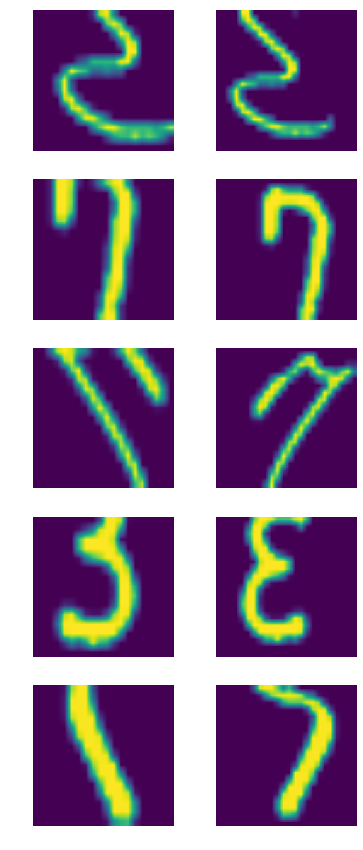

In [ ]:
learn.moco.show(n=5)

In [ ]:
learn.fit(1)

In [ ]:
learn.recorder.losses

[tensor(2.0249)]

## Export -

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 01 - augmentations.ipynb.
Converted 02 - layers.ipynb.
Converted 03 - distributed.ipynb.
Converted 10 - simclr.ipynb.
Converted 11 - moco.ipynb.
Converted 12 - byol.ipynb.
Converted 13 - swav.ipynb.
Converted 20 - clip.ipynb.
Converted 21 - clip-moco.ipynb.
Converted index.ipynb.
